This Notebook contains the first data exploration tests and the enviorornment to perform all the experiment for benchmark using the split saved locally, but ther is also the possibility to load the raw data and try a new split

### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
import logging
from tensorflow import keras
import visualkeras
from datetime import datetime
from random import shuffle
import pickle

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Metadata

In [3]:
Classes = ["Wish", "Another", "Comfortably", "Money", "Breathe", "Time", "Brain", "Echoes", "Wearing", "Sorrow", "Hey", "Shine"]

In [4]:
GIANMARIO = True

TESTSIZE = 0.15
BATCH_SIZE = 64
EPOCHS = 200
NUM_CLASSES = Classes.__len__()
PATIENCE=10 # Number of epochs with no improvement after which training will be stopped.
DROPOUT = .4

# MinMaxScaler
APPLY_MINMAX = False # Set to False if you don't want to apply MinMaxScaler
APPLY_MINMAX_CHANNELWISE = False # Set to False if you don't want to apply MinMaxScaler channelwise

# Drop features
DROP_FEATURES = False # Set to False if you don't want to drop features
TAKE_FIRST_N_CHANNELS = 2

# Augmentation
AUGMENT_DATA = False
AUGMENTATION_RATTIO=0.1
GAUSSIAN_NOISE=0.3

# Oversampling
OVERSAMPLE_DATA_WITH_AUGMENTATIO = False

# Sequences 
LAG = 1
WINDOW_SIZE = 1
STRIDE = 1
SHUFFLE_BUFFER_SIZE = 1000

# ReduceLROnPlateau
USE_REDUCE_LR_ON_PLATEAU = False # Set to False if you don't want to use ReduceLROnPlateau
FACTOR=0.5 # Factor by which the learning rate will be reduced. new_lr = lr * factor
PLATEUA_PATIENCE=5 # Number of epochs with no improvement after which learning rate will be reduced.
MIN_LR=0.00001 # Minimum learning rate

# Regularization => NOT WORKING YET
REGULARIZATION = False # Set to False if you don't want to apply L2 regularization
REGULARIZING_FACTOR = 0.005# 0.175 # L2 regularization factor

# Data exploration
DESCRIBE_DATA = True # Set to False if you don't want to see statistics on the original data
PLOT_EXAMPLES_BEFORE_SCALING = True # Set to False if you don't want to see examples of the original data
PLOT_EXAMPLES_AFTER_SCALING = False # Set to False if you don't want to see examples of the scaled data

# Saving the model
SAFE_MODEL = False # Set to False if you don't want to save the model
MODELNAME = "LargeLSTM" + str(datetime.now().strftime("%Y%m%d-%H%M%S"))
SAFE_HISTORY = False # Set to False if you don't want to save the history

# Unzip and load data

In [5]:
#!unzip training_dataset_homework2.zip

In [6]:
# Load the data
x_original = np.load('training_dataset_homework2/x_train.npy') # Shape: (2429, 36, 6)
y_original = np.load('training_dataset_homework2/y_train.npy') # Labels

print(x_original.shape)
print(y_original.shape)

(2429, 36, 6)
(2429,)


# Exploration Data Analysis (EDA)

In [7]:
if DESCRIBE_DATA:    
    # Describe the data
    print('x_original shape:', x_original.shape)
    print('y_original shape:', y_original.shape)
    print('x_original dtype:', x_original.dtype)
    print('y_original dtype:', y_original.dtype)
    print('x_original min:', x_original.min())
    print('x_original max:', x_original.max())
    print('y_original unique:', np.unique(y_original))
    print('y_original counts:', np.bincount(y_original))
    print('y_original counts:', np.bincount(y_original) / len(y_original)*100)
    print('x_original mean:', x_original.mean())
    print('x_original std:', x_original.std())


x_original shape: (2429, 36, 6)
y_original shape: (2429,)
x_original dtype: float64
y_original dtype: int32
x_original min: -11585.0
x_original max: 53020.0
y_original unique: [ 0  1  2  3  4  5  6  7  8  9 10 11]
y_original counts: [ 34 123 270 381  62 153 313  68 120 777  77  51]
y_original counts: [ 1.39975298  5.06381227 11.11568547 15.68546727  2.55249074  6.29888843
 12.8859613   2.79950597  4.94030465 31.98847262  3.17002882  2.09962948]
x_original mean: 25.295960919260704
x_original std: 658.4301638513654


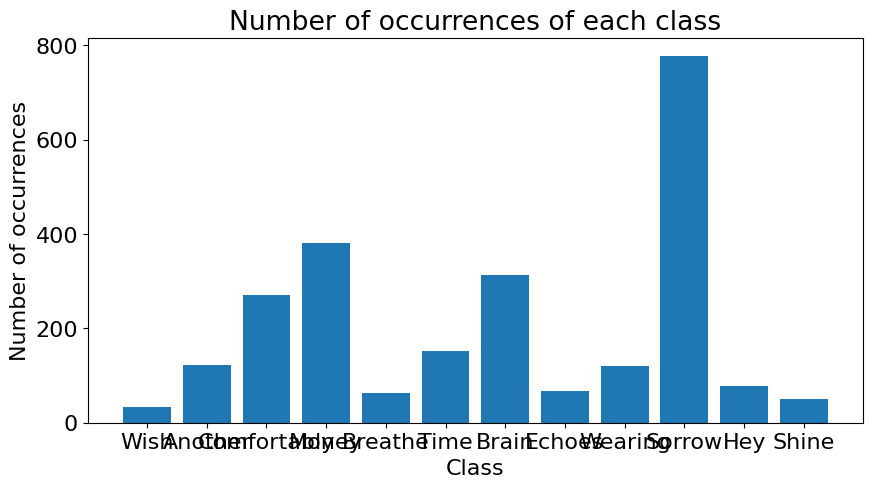

In [8]:
# plot the number of occurrences of each class
plt.figure(figsize=(10, 5))
plt.title('Number of occurrences of each class')
plt.xlabel('Class')
plt.ylabel('Number of occurrences')
plt.bar(Classes, np.bincount(y_original))
plt.show()

In [9]:
# Plot one sample
def plot_sample_before_scaling(idx):
    plt.figure(figsize=(12, 6))
    plt.plot(x_original[idx])
    plt.title('Sample ' + str(idx) + ', Label: ' + Classes[y_original[idx]])
    plt.legend(['1', '2', '3', '4', '5', '6'])
    plt.grid()
    plt.show()

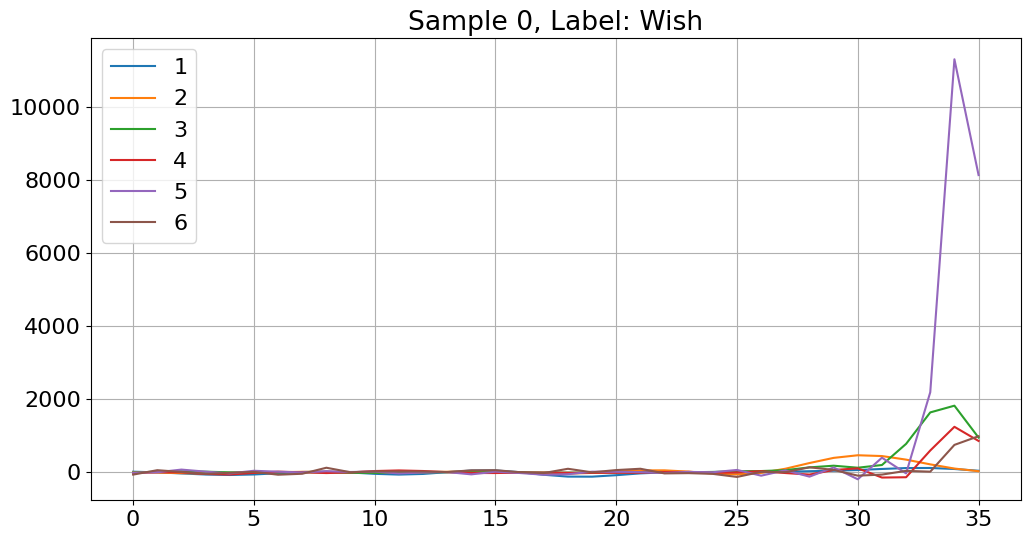

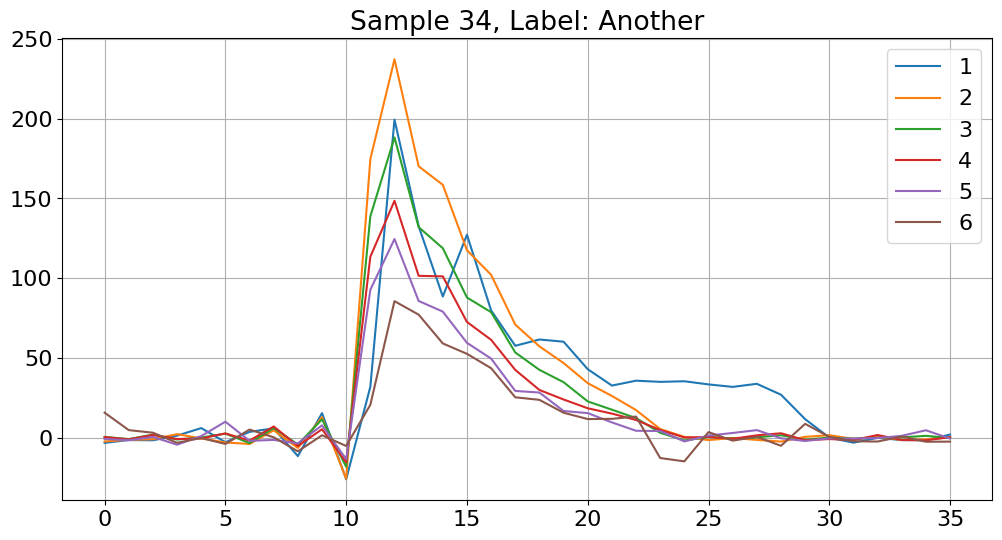

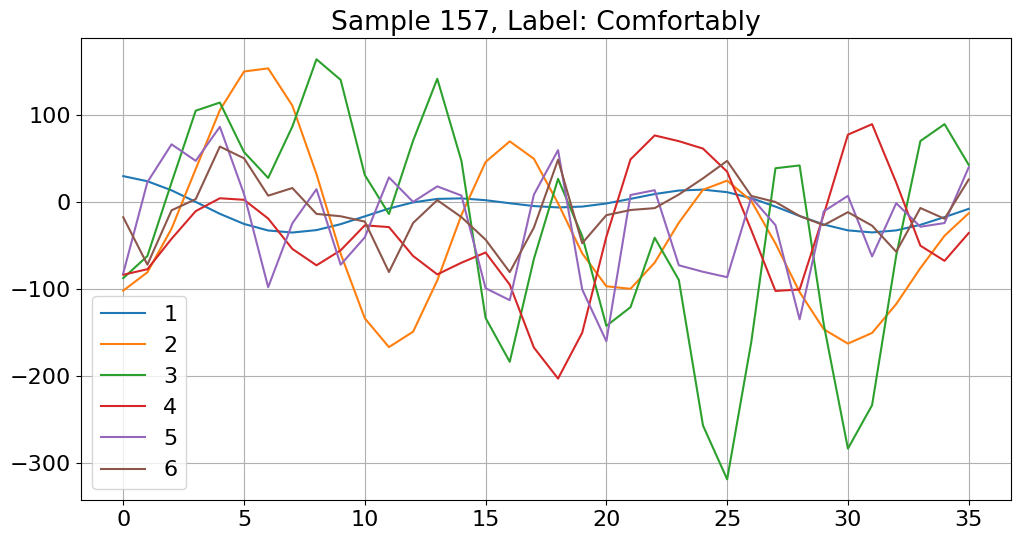

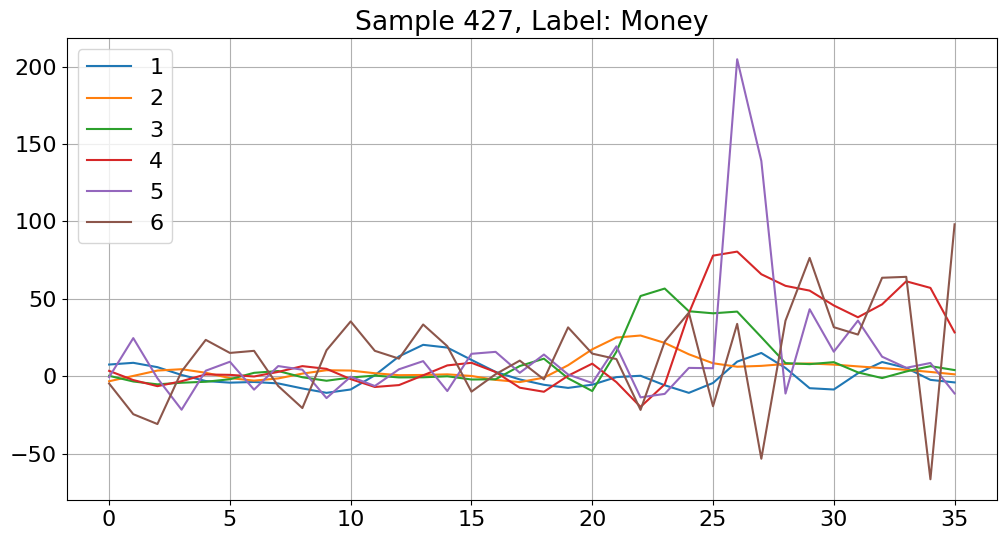

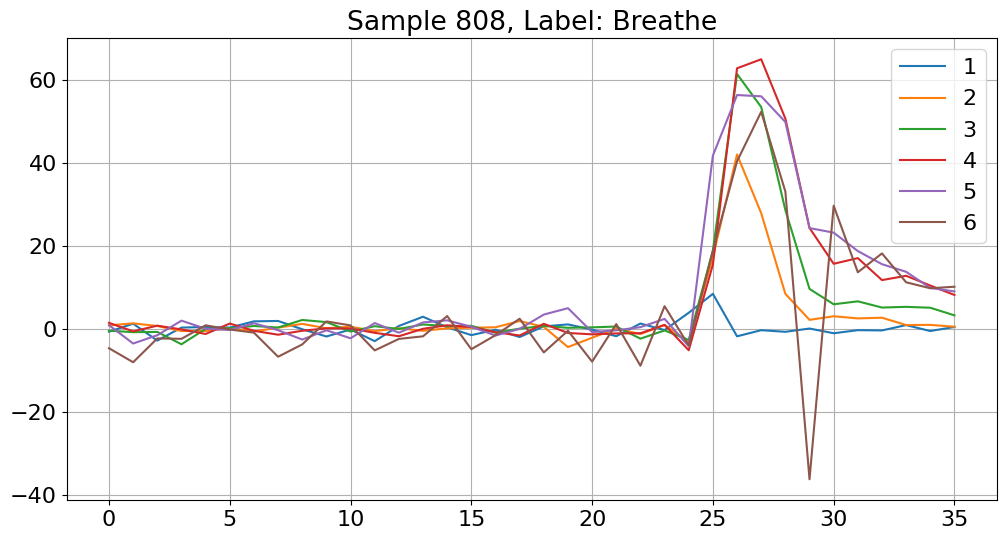

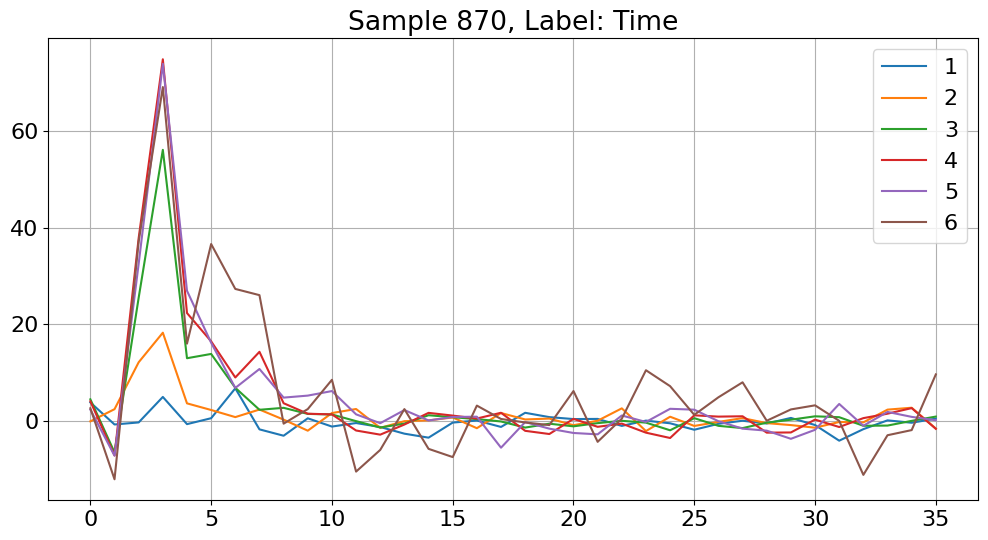

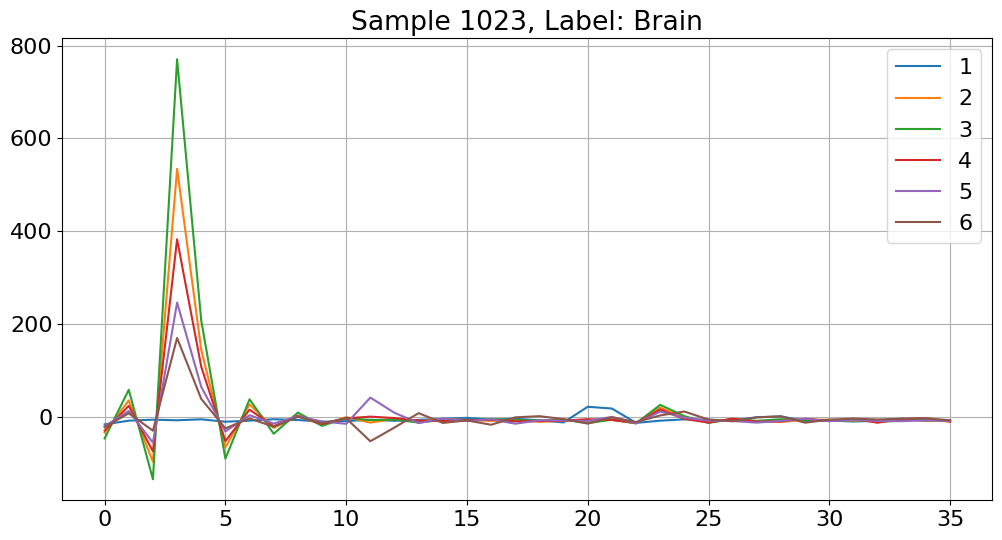

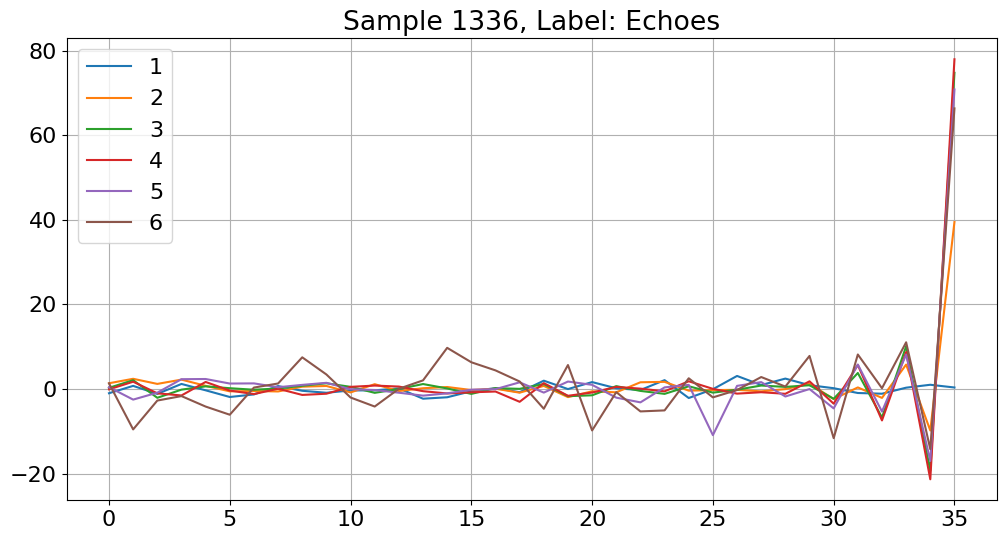

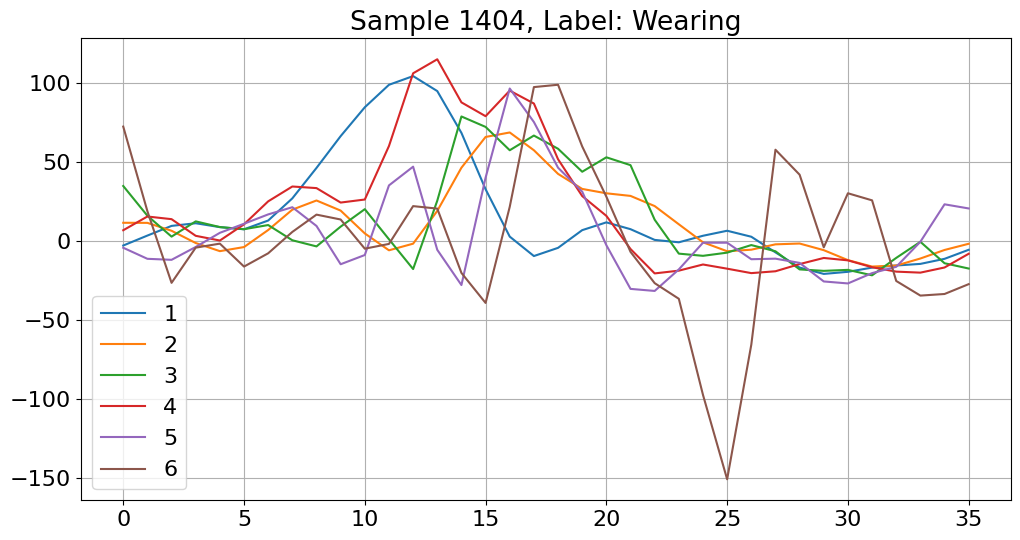

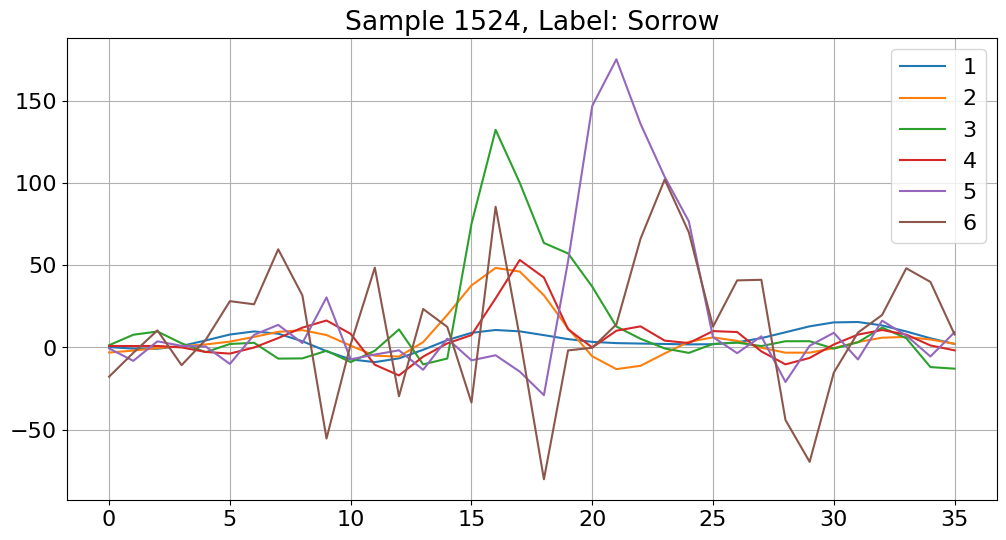

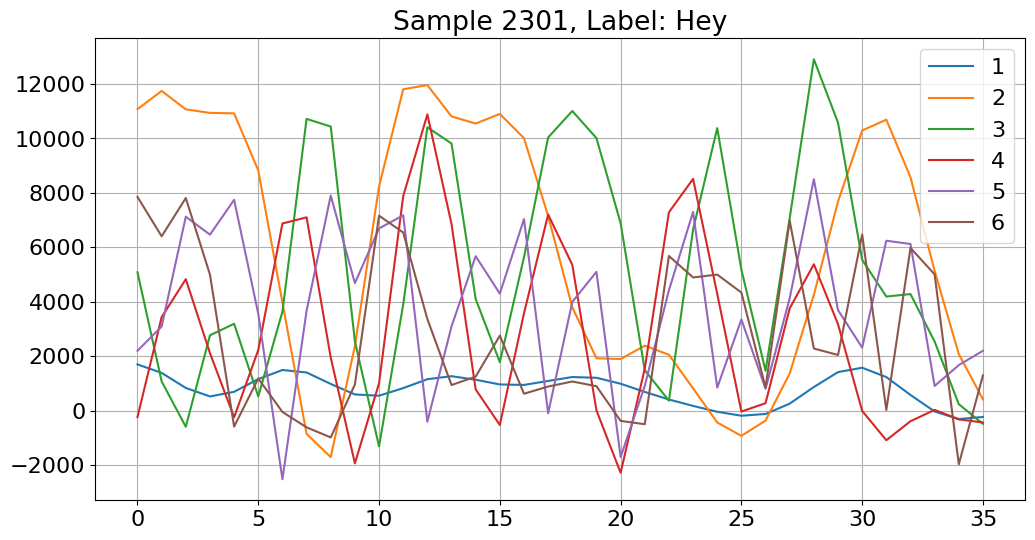

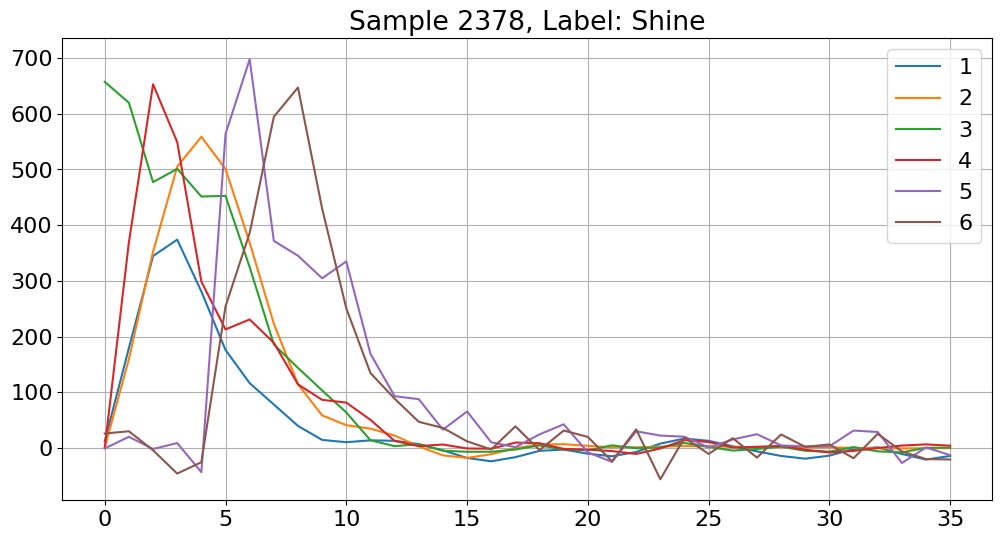

In [10]:
if PLOT_EXAMPLES_BEFORE_SCALING:
    # Plot one sample for each class
    for i in range(12):

        plot_sample_before_scaling(np.where(y_original == i)[0][0])

## t-SNE

/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


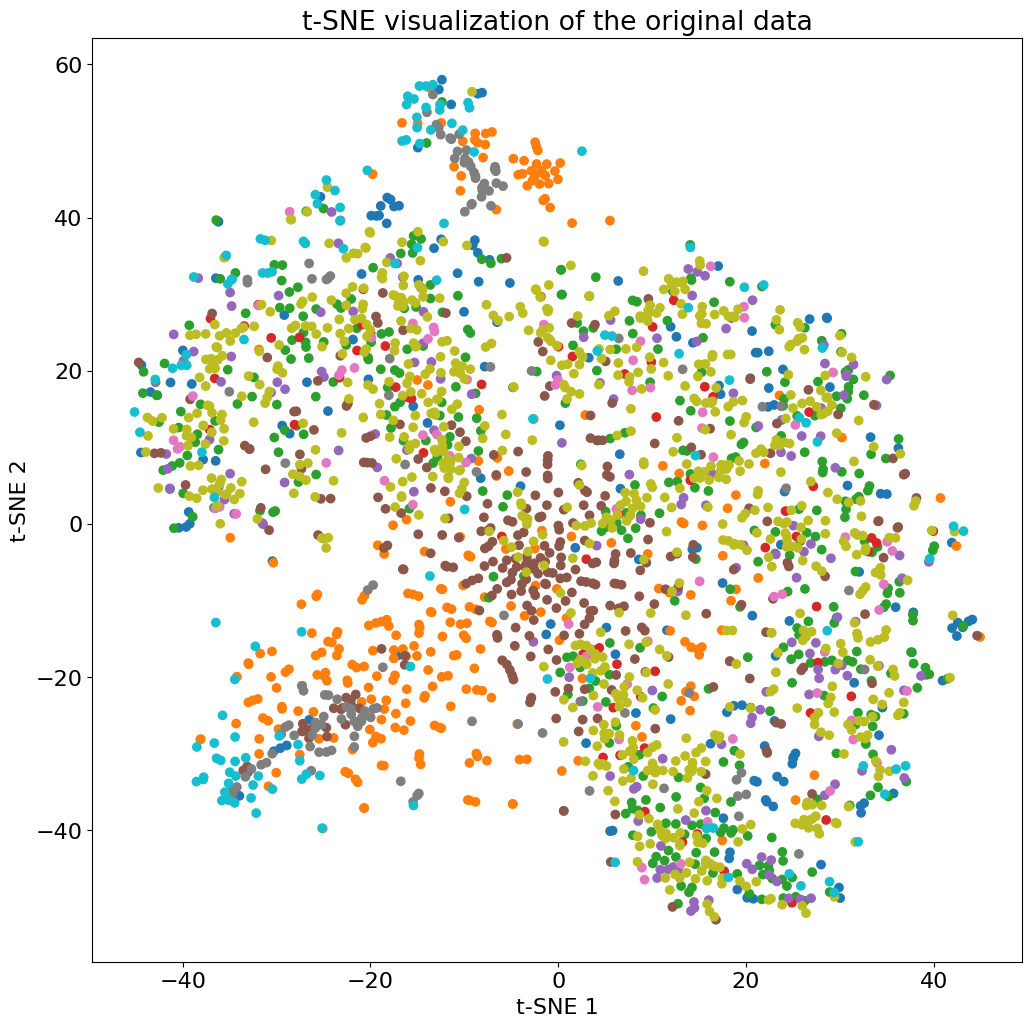

In [11]:
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
import seaborn as sns

# Plot the data in 2D using t-SNE
x_original_2d = TSNE(random_state=0).fit_transform(x_original.reshape(x_original.shape[0], -1))

# Plot the data in 2D using t-SNE
plt.figure(figsize=(12, 12))
plt.title('t-SNE visualization of the original data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.scatter(x_original_2d[:, 0], x_original_2d[:, 1], c=y_original, cmap='tab10')
plt.show()


# Preprocessing

## Drop Features

In [12]:
# Keey only the first 3 channels
if DROP_FEATURES:
    print('Dropping features...')
    print(x_original.shape)
    x_original = x_original[:, :, : TAKE_FIRST_N_CHANNELS]
    print(x_original.shape)

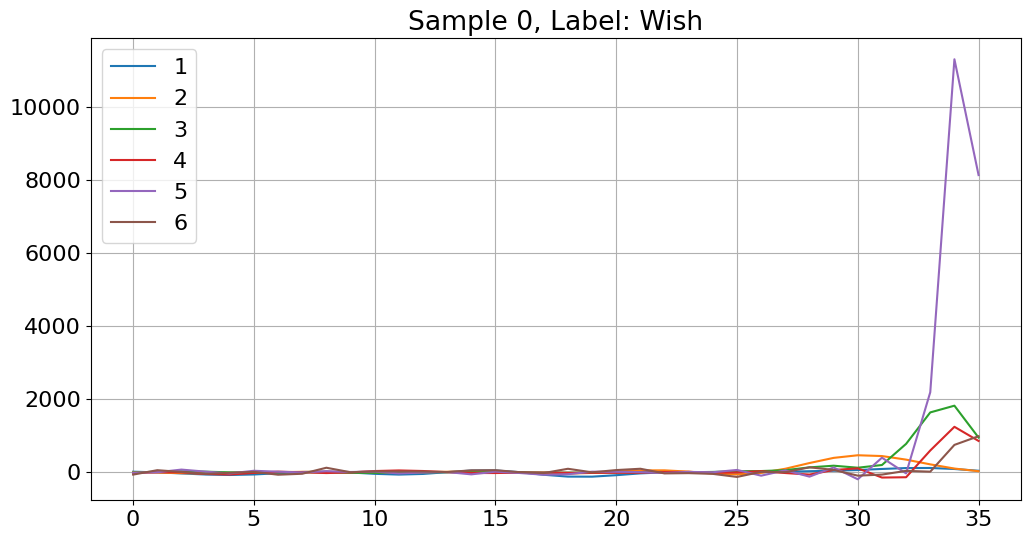

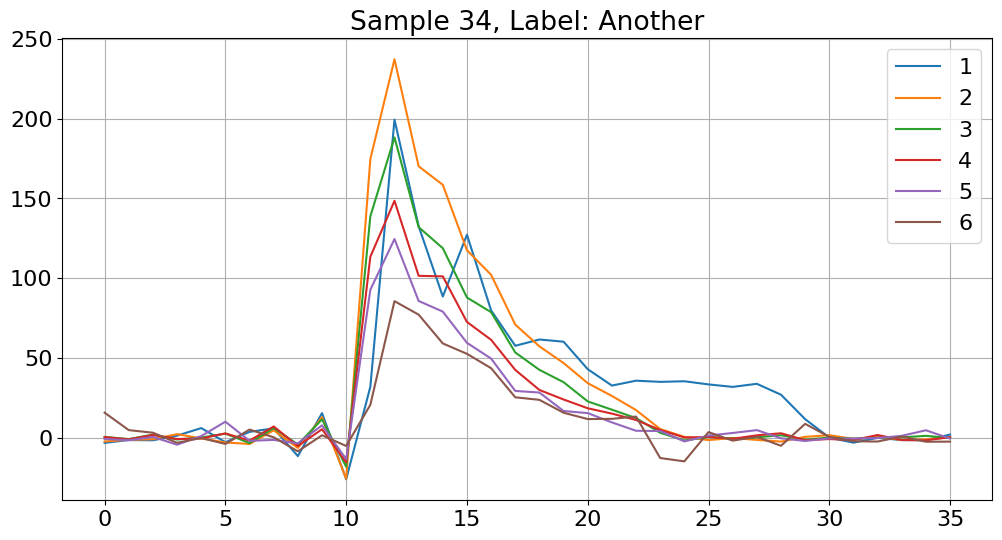

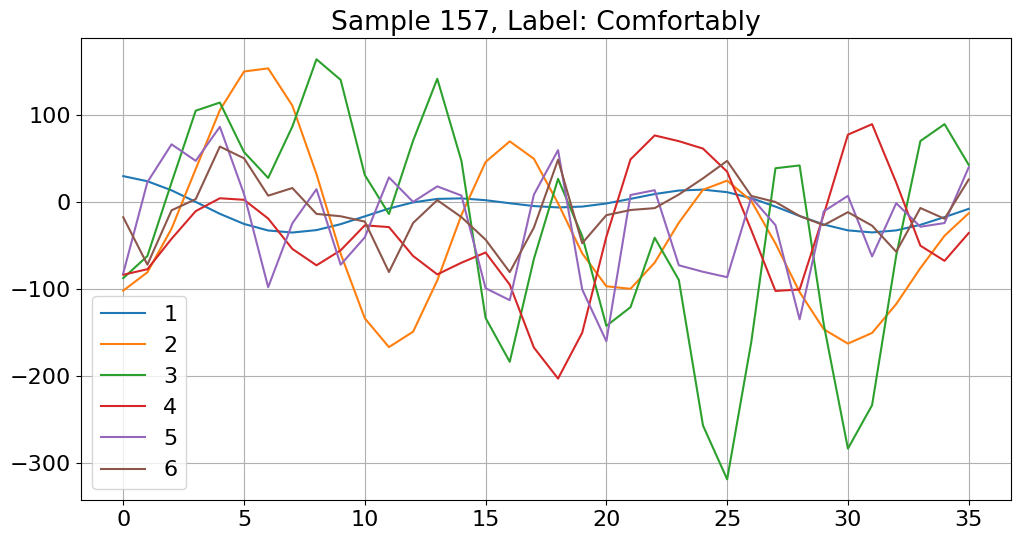

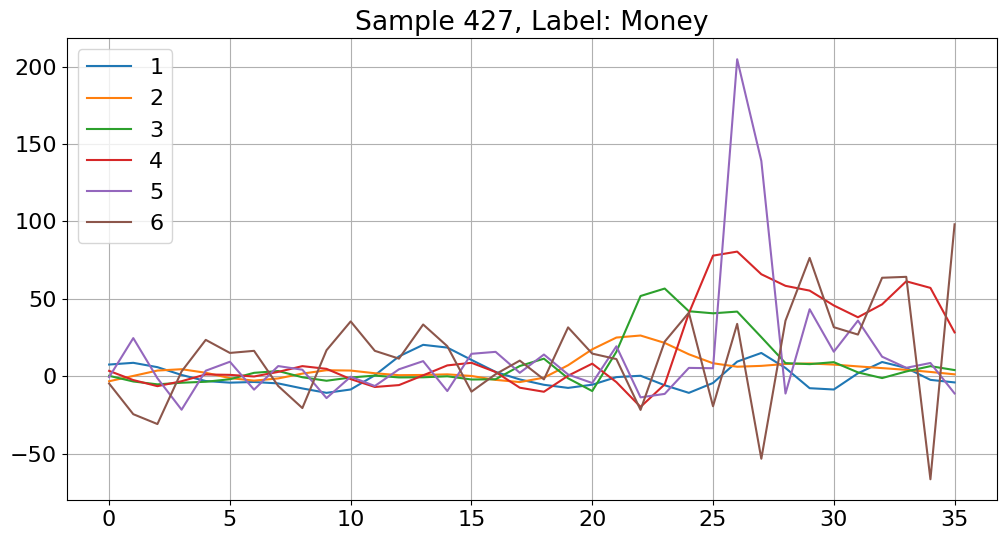

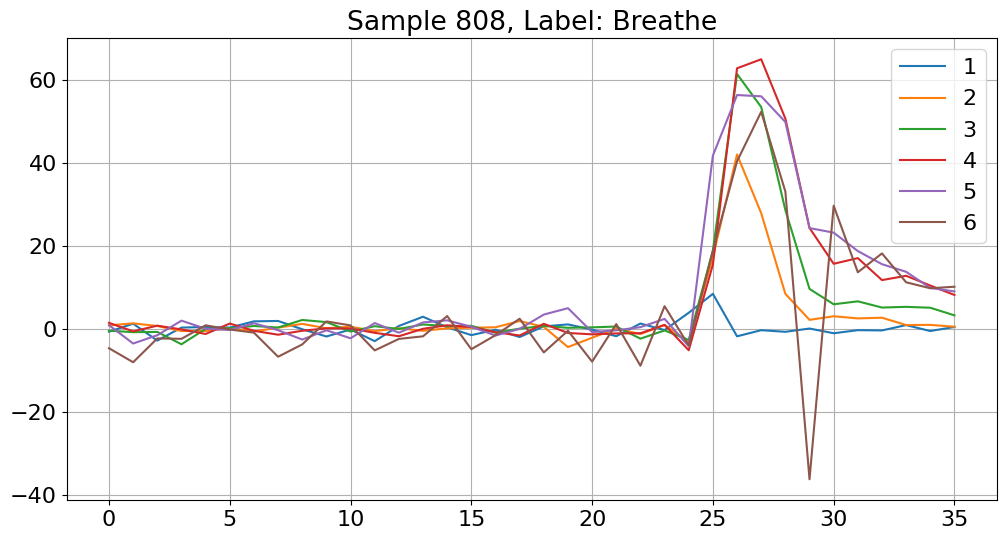

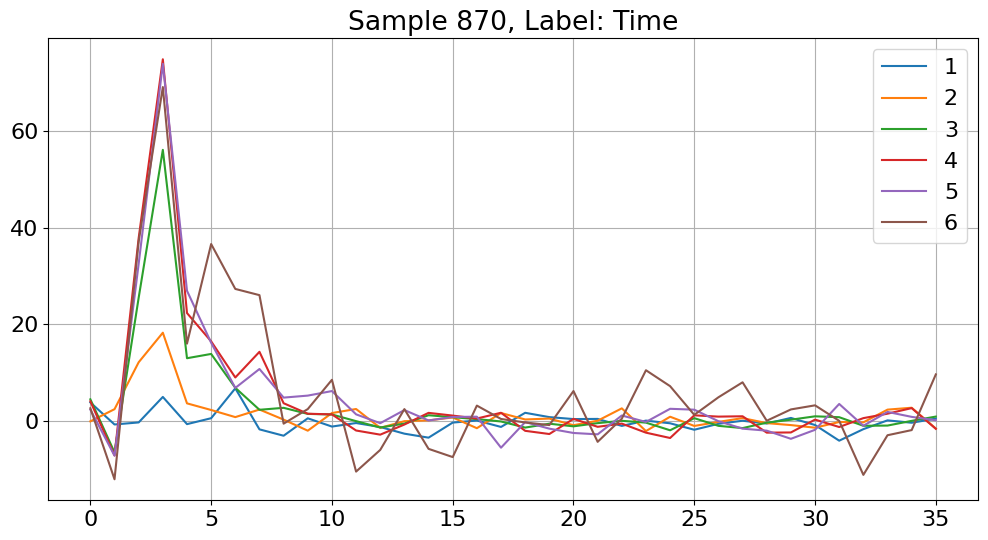

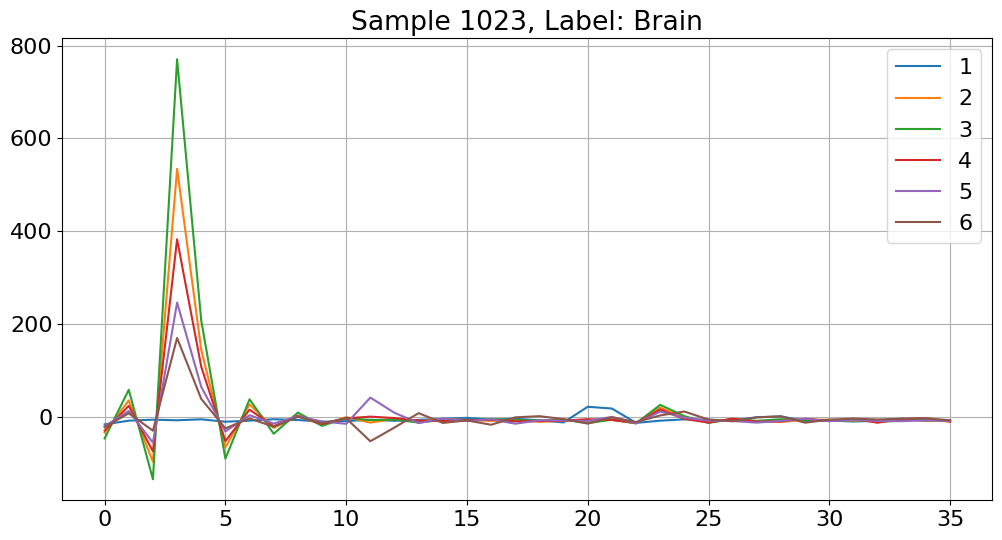

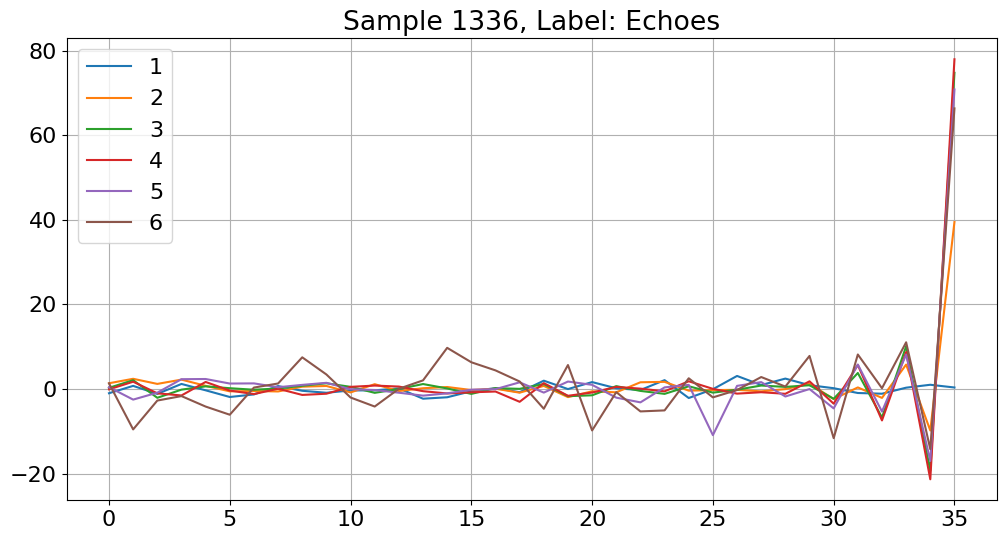

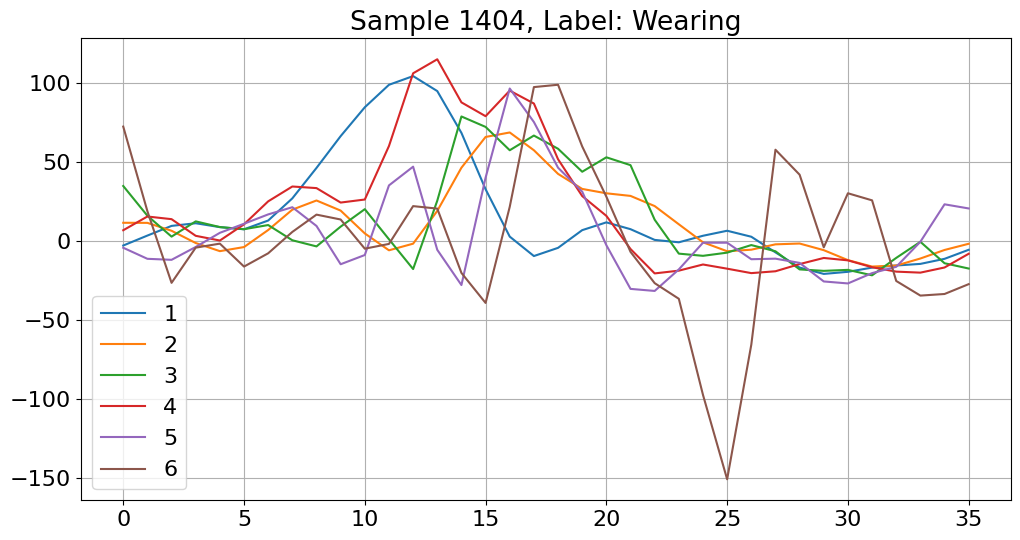

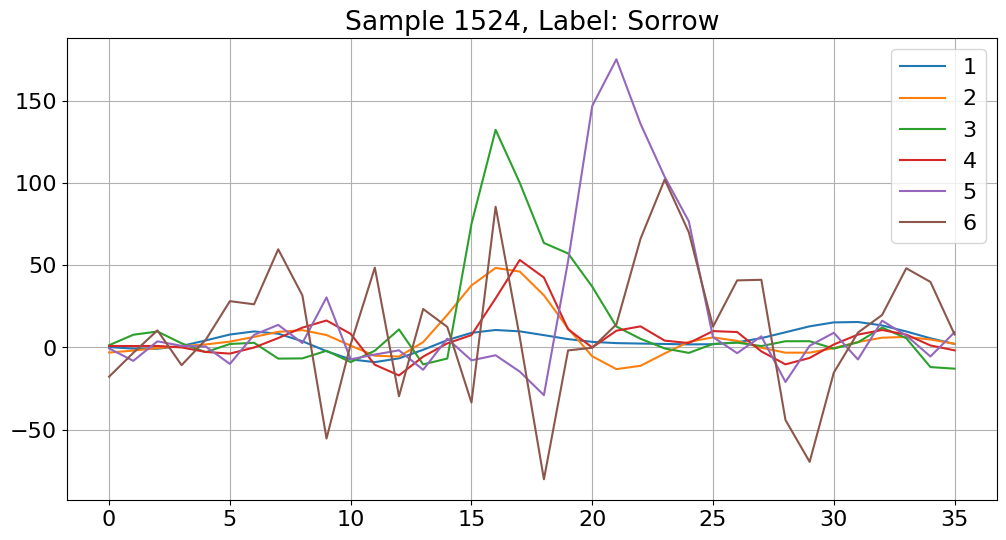

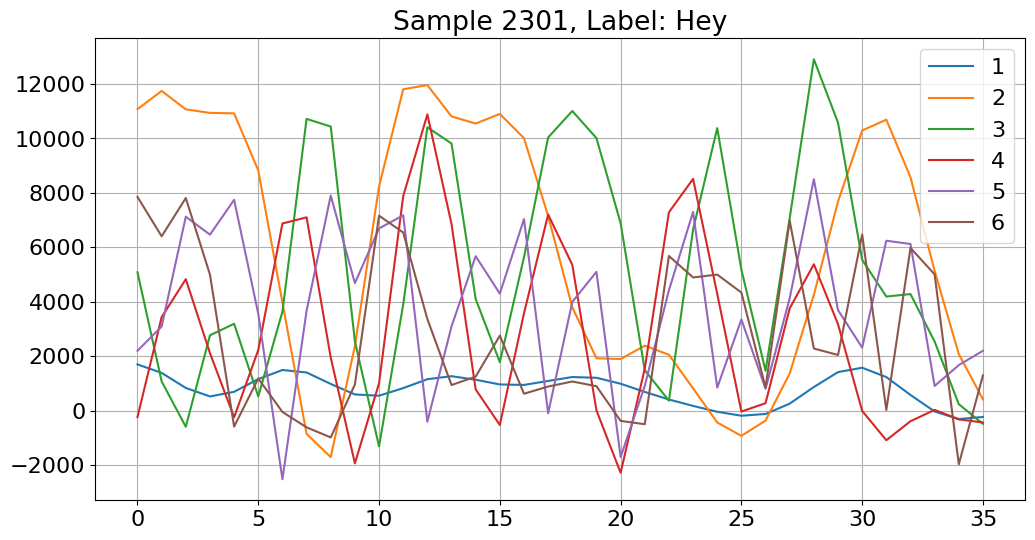

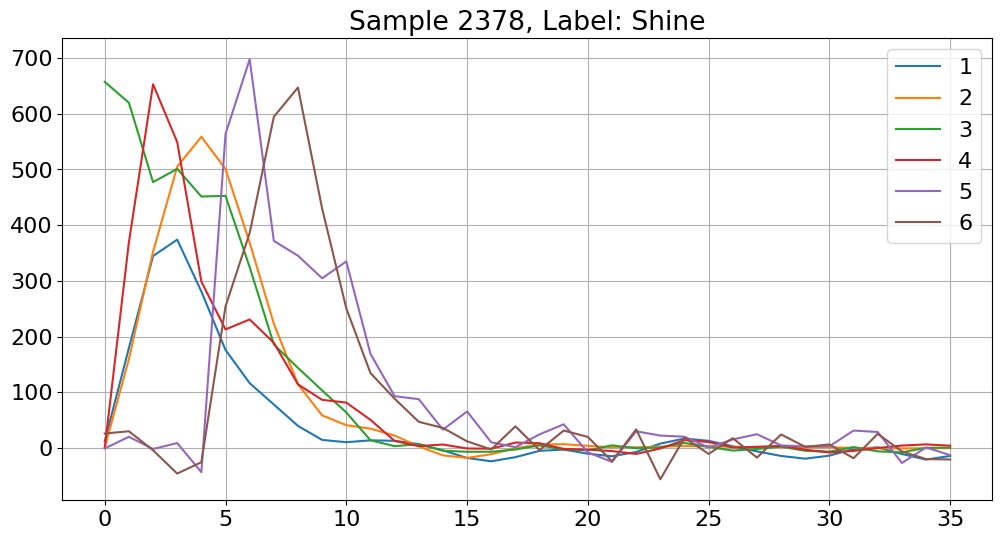

In [13]:
if PLOT_EXAMPLES_BEFORE_SCALING:
    # Plot one sample for each class
    for i in range(12):

        plot_sample_before_scaling(np.where(y_original == i)[0][0])

## Split

In [14]:
# Separate the test data
x_train, x_test, y_train, y_test = train_test_split(x_original, y_original, test_size=TESTSIZE, shuffle=True) # Shuffle the data before splitting

# TESTING OTHER SPLIT OF GIANMARIO
if GIANMARIO:
  with open("../DeepLearning-Challenges/Gianmario/train_test_obj", "rb") as f:
    x_train, x_test, y_train, y_test = pickle.load(f)

## MinMaxScaler

In [15]:
if APPLY_MINMAX:
    print('Applying MinMaxScaler across all channels...')
    scaler = MinMaxScaler()
    scaler.fit(x_train.reshape(-1, x_train.shape[-1])) # Fit only on the training data

    with open('MinMaxScalers/' + 'scaler_for_All_channels' + '.pkl', 'wb') as f:
            pickle.dump(scaler, f)
        
        # The follwing is the code to load the pickle files in the submission model:
        # Load the scalers from the pickle files
        #with open('MinMacScalers/scaler_0.pkl', 'rb') as f:
        #    scaler_0 = pickle.load(f)

    # Apply the scaler to the data
    x_train = scaler.transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
    

if APPLY_MINMAX_CHANNELWISE:
    print('Applying MinMaxScaler channelwise...')
    x_train = np.zeros(x_train.shape)
    # Fit the min-max scaler individually to each channel
    for i in range(x_train.shape[-1]):
        scaler = MinMaxScaler()
        scaler.fit(x_train[:, :, i].reshape(-1, 1)) # Fit only on the training data
         # Apply the scaler to the data
        x_train[:, :, i] = scaler.transform(x_train[:, :, i].reshape(-1, 1)).reshape(x_train[:, :, i].shape)
        x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
        
        # Save the scaler for later use as pickle file
        with open('MinMaxScalers/' + 'scaler_' + str(i) + '.pkl', 'wb') as f:
            pickle.dump(scaler, f)
        
        # The follwing is the code to load the pickle files in the submission model:
        # Load the scalers from the pickle files
        #with open('MinMacScalers/scaler_0.pkl', 'rb') as f:
        #    scaler_0 = pickle.load(f)

## RobustScaler

In [16]:
if GIANMARIO:
    # load scaler
    with open("./scaler.p", "rb") as f:
        scaler = pickle.load(f)
        x_train[:, :, i] = scaler.transform(x_train[:, :, i].reshape(-1, 1)).reshape(x_train[:, :, i].shape)
        x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

FileNotFoundError: [Errno 2] No such file or directory: './scaler.p'

In [ ]:
# Plot one sample
def plot_sample_after_scaling(idx):
    plt.figure(figsize=(5,2))
    plt.plot(x_train[idx])
    plt.title('Sample ' + str(idx) + ', Label: ' + Classes[y_original[idx]])
    #plt.legend(['1', '2', '3', '4', '5', '6'])
    plt.grid()
    plt.show()

PLOT_EXAMPLES_AFTER_SCALING = False
if PLOT_EXAMPLES_AFTER_SCALING:
    # Plot one sample for each class
    for i in range(NUM_CLASSES):
        plot_sample_after_scaling(np.where(y_original == i)[0][0])

## Feature Engineering

In [ ]:
# Funtion that finds the feature with the highest variance
# These will carry the most information

# print the variance of each feature
print('Variance of each feature:')
for i in range(x_train.shape[-1]):
    print('Feature', i, 'variance:', np.var(x_train[:, :, i]))
    
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# Try different feature selection methods
def select_features(x, y, method='variance', n_features=3):
    if method == 'variance':
        # Select the features with the highest variance
        feature_selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
        x = feature_selector.fit_transform(x)
        print('Variance of each feature:')
        print(feature_selector.variances_)
        print('Selected features:')
        print(feature_selector.get_support())
        print('Number of selected features:')
        print(np.sum(feature_selector.get_support()))
        return x
    elif method == 'univariate':
        # Select the features with the highest univariate F-test scores
        feature_selector = SelectKBest(f_classif, k=n_features)
        x = feature_selector.fit_transform(x, y)
        print('F-test scores of each feature:')
        print(feature_selector.scores_)
        print('Selected features:')
        print(feature_selector.get_support())
        print('Number of selected features:')
        print(np.sum(feature_selector.get_support()))
        return x
    elif method == 'recursive':
        # Select the features with the highest recursive F-test scores
        feature_selector = RFE(estimator=LogisticRegression(), n_features_to_select=n_features, step=1)
        x = feature_selector.fit_transform(x, y)
        print('Recursive F-test scores of each feature:')
        print(feature_selector.ranking_)
        print('Selected features:')
        print(feature_selector.get_support())
        print('Number of selected features:')
        print(np.sum(feature_selector.get_support()))
        return x
    elif method == 'model':
        # Select the features with the highest model-based feature importance scores
        feature_selector = SelectFromModel(estimator=LogisticRegression(), max_features=n_features)
        x = feature_selector.fit_transform(x, y)
        print('Model-based feature importance scores of each feature:')
        print(feature_selector.estimator_.coef_)
        print('Selected features:')
        print(feature_selector.get_support())
        print('Number of selected features:')
        print(np.sum(feature_selector.get_support()))
        return x
    else:
        print('Invalid feature selection method.')
        return x
    

Variance of each feature:
Feature 0 variance: 46281.58329691905
Feature 1 variance: 576613.3113849916
Feature 2 variance: 467762.00140909327
Feature 3 variance: 460700.25044987554
Feature 4 variance: 450781.5704652029
Feature 5 variance: 501116.6471833122


## Augmentation

### Augment the entire dataset by a ratio

In [ ]:
# Funtion that augments the x_train data. It takes as input the x_train data and the y_train labels and returns the augmented x_train data and the corresponding y_train labels
# The augmentation is done by adding small random noise to some of the x_train samples and then add them to the x_train data
# The augment_ratio parameter is the ratio of the number of augmented samples to the number of original samples
# The x_train and y_train data are shuffled before returning

if AUGMENT_DATA:
    print('x_train shape before augmentation:', x_train.shape)
    print('y_train shape before augmentation:', y_train.shape)

    def augment_data(x_train, y_train, AUGMENTATION_RATTIO, GAUSSIAN_NOISE):
        print('Gaussian noise:', GAUSSIAN_NOISE)
        print('Augment ratio:', AUGMENTATION_RATTIO)
        # Add random noise to some of the samples
        x_train_augmented = np.zeros((int(x_train.shape[0]*AUGMENTATION_RATTIO), x_train.shape[1], x_train.shape[2]))
        y_train_augmented = np.zeros(int(x_train.shape[0]*AUGMENTATION_RATTIO), dtype=np.int8)
        for i in range(x_train_augmented.shape[0]):
            # Randomly select a sample from the x_train data
            idx = np.random.randint(0, x_train.shape[0])
            # Add random noise to the selected sample
            x_train_augmented[i] = x_train[idx] + np.random.normal(0, GAUSSIAN_NOISE, x_train[idx].shape)
            # Add the label of the selected sample to the y_train_augmented labels
            y_train_augmented[i] = y_train[idx]
            
             
            plt.figure(figsize=(7,3))
            plt.plot(x_train_augmented[i][-1])
            plt.plot(x_train[idx][-1], alpha=0.5, color='black')
            plt.title('Sample ' + str(i) + ', Label: ' + Classes[y_train_augmented[i]])
            plt.legend(['1', '2', '3', '4', '5', '6'])
            plt.grid()
            plt.show()
            
            
            
        # Concatenate the original x_train data with the augmented x_train data
        x_train = np.concatenate((x_train, x_train_augmented), axis=0)
        # Concatenate the original y_train data with the augmented y_train data
        y_train = np.concatenate((y_train, y_train_augmented), axis=0)
        
        # Shuffle the data
        p = np.random.permutation(len(x_train))
        x_train = x_train[p]
        y_train = y_train[p]
        
        print('x_train shape:', x_train.shape)
        print('y_train shape:', y_train.shape)
        return x_train, y_train

    x_train, y_train = augment_data(x_train, y_train, AUGMENTATION_RATTIO, GAUSSIAN_NOISE)

### Oversample the minority class with augmentated data

In [ ]:

# Oversample the minority classes
if OVERSAMPLE_DATA_WITH_AUGMENTATIO:
    # Drop the 300 samples of the class 9
    x_train = np.delete(x_train, np.where(y_train == 9)[0][:300], axis=0)
    y_train = np.delete(y_train, np.where(y_train == 9)[0][:300], axis=0)
    def oversample_minority_classes(x_train, y_train):
        # Count the number of samples for each class
        unique, counts = np.unique(y_train, return_counts=True)
        print('Number of samples for each class before oversampling:', dict(zip(unique, counts)))
        # Oversample the minority classes
        minority_classes = np.where(counts < np.mean(counts))[0]
        for i in minority_classes:
            # Calculate the number of samples to add
            num_samples_to_add = int(np.mean(counts)) - counts[i]
            print('Number of samples to add for class', i, ':', num_samples_to_add)
            # Randomly select samples from the x_train data that belong to the minority class i
            idx = np.random.choice(np.where(y_train == i)[0], num_samples_to_add)
        
            """
            DATA AUGMENTATION
            """
            # Augment the selected sample by adding random noise
            augmented_samples = x_train[idx] + np.random.normal(0, GAUSSIAN_NOISE, x_train[idx].shape)
            
            
            # Add the selected samples to the x_train data
            x_train = np.concatenate((x_train, augmented_samples), axis=0)
            # Add the corresponding labels to the y_train data
            y_train = np.concatenate((y_train, y_train[idx]), axis=0)
            
        # Count the number of samples for each class
        unique, counts = np.unique(y_train, return_counts=True)
        print('Number of samples for each class after oversampling:', dict(zip(unique, counts)))
        
        # Shuffle the data
        p = np.random.permutation(len(x_train))
        x_train = x_train[p]
        y_train = y_train[p]
        
        return x_train, y_train
    x_train, y_train = oversample_minority_classes(x_train, y_train)
    # plot the number of occurrences of each class
    plt.figure(figsize=(10, 5))
    plt.title('Number of occurrences of each class')
    plt.xlabel('Class')
    plt.ylabel('Number of occurrences')
    plt.bar(Classes, np.bincount(y_train))
    plt.show()

## Transform into TF Dataset

In [ ]:
# Transfrom the arrays into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-22 13:00:25.513196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-22 13:00:25.513301: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Make Class Weights using Naive method

### Custom Weights

In [ ]:
# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

def get_class_weight(y):
    total_samples = len(y)
    class_weight = {}
    for i in range(NUM_CLASSES):
        class_weight[i] = 1 - (np.bincount(y)[i] / total_samples)
    return class_weight

class_weight = get_class_weight(y_original)
class_weight

{0: 0.986002470152326,
 1: 0.9493618773157678,
 2: 0.8888431453272951,
 3: 0.8431453272951832,
 4: 0.9744750926307122,
 5: 0.9370111156854672,
 6: 0.8711403869905311,
 7: 0.9720049403046521,
 8: 0.9505969534787979,
 9: 0.6801152737752161,
 10: 0.968299711815562,
 11: 0.9790037052284891}

### Sklearn Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_original),
                                        y = y_original                                                    
                                    )
class_weight = dict(zip(np.unique(y_original), class_weights))
#class_weight

# Build Model

## 1: CNN

Test accuracy 0.630137026309967
Test loss 1.1128861904144287

In [ ]:
def Conv1D_BN_ReLu_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.GlobalAveragePooling1D()(x)

    output_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

## 2: LSTM

Test accuracy 0.6602739691734314
Test loss 1.210566759109497

In [ ]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(32, return_sequences=True)(input_layer) # retunr_sequences=True is used to return the output of each cell
    lstm = tfkl.LSTM(32, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(32, return_sequences=True)(lstm) 
    lstm = tfkl.LSTM(32)(lstm)
    dropout = tfkl.Dropout(DROPOUT, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(64, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

## 3: CNN from Lab

Test accuracy 0.3374485373497009
Test loss 119.46961212158203

In [ ]:
def CC_from_Lab(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.MaxPool1D()(x)
    
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.MaxPool1D()(x)
    
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    x = keras.layers.MaxPool1D()(x)
    
    x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    
    output_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

## 4: Bidirectional LSTM

In [ ]:
from tensorflow.keras import regularizers

def bidirectional_LSTM(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(input_layer)
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(x)
    if REGULARIZATION:
        x = keras.layers.Dense(32, kernel_regularizer=regularizers.l2(REGULARIZING_FACTOR), activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    
    output_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
from tensorflow.keras import regularizers

def bidirectional_LSTM_New(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(input_layer)
    x = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(input_layer)
    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(x)
    if REGULARIZATION:
        x = keras.layers.Dense(32, kernel_regularizer=regularizers.l2(REGULARIZING_FACTOR), activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    
    output_layer = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

# Fit the model

## Choose which model to fit

In [ ]:
#model = Conv1D_BN_ReLu_model(input_shape=x_train.shape[1:]) 

#model = build_LSTM_classifier(input_shape=x_train.shape[1:], classes=NUM_CLASSES)

#model = CC_from_Lab(input_shape=x_train.shape[1:])

model = bidirectional_LSTM(input_shape=x_train.shape[1:])

#model = bidirectional_LSTM_New(input_shape=x_train.shape[1:])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 64)           9984      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

## Train

In [ ]:
if USE_REDUCE_LR_ON_PLATEAU:
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", 
            factor=FACTOR, 
            patience=PLATEUA_PATIENCE, 
            min_lr= MIN_LR, 
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", 
            patience = PATIENCE, 
            verbose=1,
            restore_best_weights=True
        ), 
    ]
else:
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss", 
            patience = PATIENCE, 
            verbose=1), 
    ]

In [ ]:
model.compile(
    optimizer= keras.optimizers.Adam(),
    #loss="sparse_categorical_crossentropy",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data= test_dataset,
    verbose=1,
    #class_weight= class_weight
)

Epoch 1/200


2022-12-22 13:00:28.686920: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-22 13:00:28.698704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:00:29.028581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:00:29.045163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:00:29.203407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:00:29.221629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:00:29.430954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

31/31 [==============================] - ETA: 0s - loss: 2.2023 - sparse_categorical_accuracy: 0.3078

2022-12-22 13:00:32.778312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:00:32.910875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:00:32.924200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:00:33.041892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:00:33.052824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 7s 120ms/step - loss: 2.2023 - sparse_categorical_accuracy: 0.3078 - val_loss: 1.9696 - val_sparse_categorical_accuracy: 0.3539
Epoch 2/200
31/31 [==============================] - 2s 51ms/step - loss: 1.9082 - sparse_categorical_accuracy: 0.4020 - val_loss: 1.7435 - val_sparse_categorical_accuracy: 0.4403
Epoch 3/200
31/31 [==============================] - 2s 51ms/step - loss: 1.6839 - sparse_categorical_accuracy: 0.4545 - val_loss: 1.5863 - val_sparse_categorical_accuracy: 0.4486
Epoch 4/200
31/31 [==============================] - 2s 51ms/step - loss: 1.5111 - sparse_categorical_accuracy: 0.4972 - val_loss: 1.4486 - val_sparse_categorical_accuracy: 0.4774
Epoch 5/200
31/31 [==============================] - 2s 51ms/step - loss: 1.3879 - sparse_categorical_accuracy: 0.5198 - val_loss: 1.3773 - val_sparse_categorical_accuracy: 0.4877
Epoch 6/200
31/31 [==============================] - 2s 53ms/step - loss: 1.2877 - sparse_categorical_accuracy:

## Find best regularization factor

In [ ]:
# Funtion that finds the best regularization factor
def find_best_regularization_factor():
    regularization_factors = [0.075, 0.1, 0.125, 0.15, 0.175, 0.2] # 0.175 is the best for bidirectional LSTM
    best_regularization_factor = 0
    best_accuracy = 0
    for regularization_factor in regularization_factors:
        model = bidirectional_LSTM(input_shape=x_train.shape[1:])
        model.compile(
            optimizer="adam",
            #loss="sparse_categorical_crossentropy",
            loss = tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=["sparse_categorical_accuracy"],
        )
        history = model.fit(
            train_dataset,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=callbacks,
            validation_data= test_dataset,
            verbose=1,
            class_weight= class_weight
        )
        if history.history["val_sparse_categorical_accuracy"][-1] > best_accuracy:
            best_accuracy = history.history["val_sparse_categorical_accuracy"][-1]
            best_regularization_factor = regularization_factor
    return best_regularization_factor

#REGULARIZING_FACTOR = find_best_regularization_factor()

In [ ]:
# Function that performs gird search to find the best batch size and patience
def find_best_batch_size_and_patience():
    batch_sizes = [16, 32, 64, 128, 256, 512]
    best_batch_size = 0
    best_patience = 0
    best_accuracy = 0
    for batch_size in batch_sizes:
        for PATIENCE in range(1, 10):
            model = bidirectional_LSTM(input_shape=x_train.shape[1:])
            model.compile(
                optimizer="adam",
                #loss="sparse_categorical_crossentropy",
                loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["sparse_categorical_accuracy"],
            )
            history = model.fit(
                train_dataset,
                batch_size=batch_size,
                epochs=EPOCHS,
                callbacks=callbacks,
                validation_data= test_dataset,
                verbose=1,
                class_weight= class_weight
            )
            if history.history["val_sparse_categorical_accuracy"][-1] > best_accuracy:
                best_accuracy = history.history["val_sparse_categorical_accuracy"][-1]
                best_batch_size = batch_size
                best_patience = PATIENCE
    return best_batch_size, best_patience

#best_batch_size, best_patience = find_best_batch_size_and_patience() # best_batch_size = 16, best_patience = 3

# Evaluate Model

## Test Accuracy and Loss

In [ ]:
#model = keras.models.load_model("./Fully_Convolutional_Neural_Network/")
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("\n")
print("Test accuracy", test_acc)
print("Test loss", test_loss)

2022-12-22 13:01:16.929261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:01:17.044045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:01:17.054650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:01:17.164243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:01:17.175707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 - 2s - loss: 1.4919 - sparse_categorical_accuracy: 0.5988 - 2s/epoch - 95ms/step


Test accuracy 0.5987654328346252
Test loss 1.4919394254684448


In [ ]:
# Predict the test set 
predictions = model.predict(test_dataset)

2022-12-22 13:01:18.493216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:01:18.602431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:01:18.613154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/8 [==========>...................] - ETA: 0s

2022-12-22 13:01:18.720269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:01:18.731366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 52ms/step


## F1 Score

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix
f1_score = sklearn.metrics.f1_score(y_test, predictions.argmax(axis=1), average='macro')
print("F1 score", f1_score)

F1 score 0.401850207033946


## Plot training and validation accuracy values

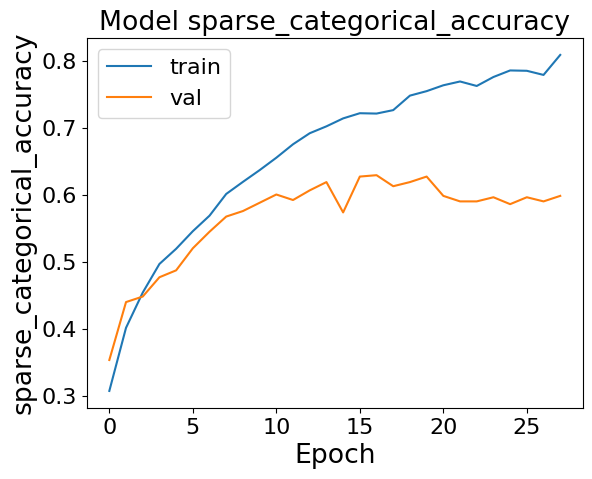

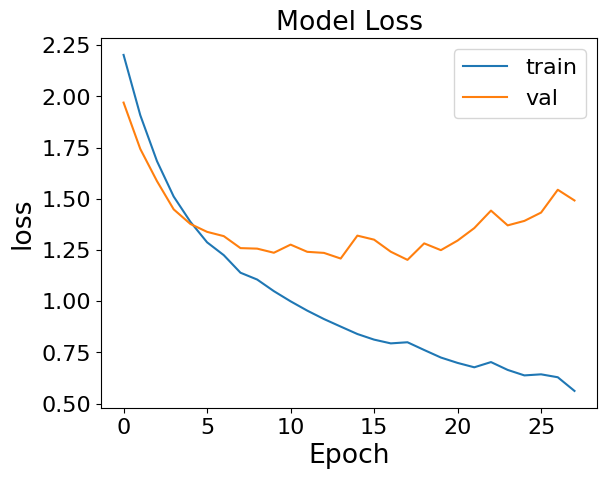

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

# Plot the loss function
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss", fontsize="large")
plt.xlabel("Epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

## Confusion Matrix

Normalized confusion matrix
[[0.         0.         0.         0.         0.         0.
  0.25       0.         0.25       0.         0.         0.5       ]
 [0.         0.5        0.04545455 0.13636364 0.         0.
  0.04545455 0.         0.13636364 0.13636364 0.         0.        ]
 [0.         0.         0.86666667 0.         0.         0.
  0.04444444 0.         0.         0.02222222 0.06666667 0.        ]
 [0.         0.02409639 0.         0.60240964 0.         0.
  0.03614458 0.03614458 0.         0.27710843 0.         0.02409639]
 [0.         0.         0.         0.30769231 0.         0.
  0.         0.         0.         0.69230769 0.         0.        ]
 [0.         0.125      0.         0.40625    0.         0.09375
  0.125      0.         0.         0.25       0.         0.        ]
 [0.01449275 0.04347826 0.04347826 0.01449275 0.         0.
  0.66666667 0.         0.01449275 0.20289855 0.         0.        ]
 [0.         0.         0.         0.25       0.         0.
  0.

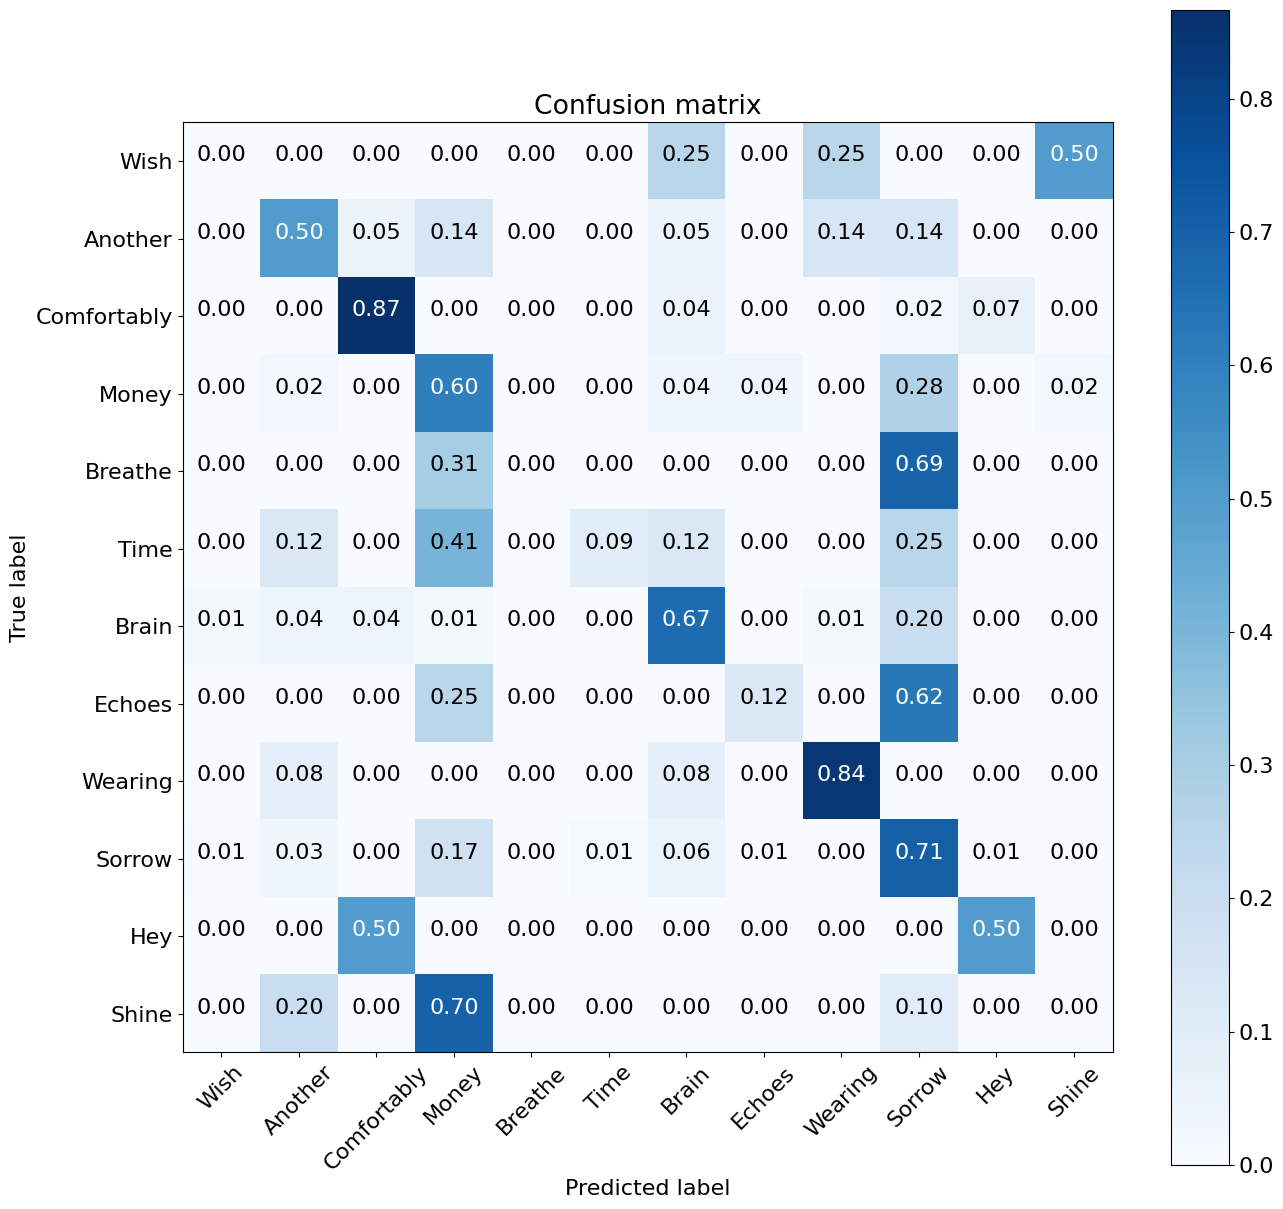

In [ ]:
# Funtion that plots the confusion matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(confusion_matrix(y_test, predictions.argmax(axis=1)), classes=Classes, normalize=True) 

## Recall, Precision, Specificity, Accuracy

In [ ]:
# Print recall, precision, specificity, accuracy, F1 score
def print_metrics(y_true, y_pred):
    print("Recall: ", recall_score(y_true, y_pred, average='macro'))
    #print("Precision: ", precision_score(y_true, y_pred, average='macro'))
    print("Specificity: ", recall_score(y_true, y_pred, average='macro'))
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    
    
print_metrics(y_test, predictions.argmax(axis=1))

Recall:  0.4084582784428585
Specificity:  0.4084582784428585
Accuracy:  0.5987654320987654


# Save model

In [ ]:
# Save model
if SAFE_MODEL:
    model.save('SavedModels/' + MODELNAME)
    print("Model saved")

INFO:tensorflow:Assets written to: SavedModels/LargeLSTM20221222-130011/assets


INFO:tensorflow:Assets written to: SavedModels/LargeLSTM20221222-130011/assets


Model saved


# Save this history as pickle file

In [ ]:
import pickle
if SAFE_HISTORY:
    print("Saving history")
    # Save the history of the model as a pickle file
    with open('SavedModels/' +  MODELNAME + '/history.pickle', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    print("History saved")
# Load the history of the model
#with open('SavedModels/LSTM_history.pickle', 'rb') as file_pi:
#    history = pickle.load(file_pi)

Saving history
History saved
